# Predicting Movie Revenue

## Features  

**Variable to Predict:** Revenue


- Budget  
- Runtime  
- Genre  
- Release Date  
 - Season  
 - Holiday   
- Production Companies  
 - Number of companies involved  
 - Number of movies a company has made (previously)  
- Crew
 - Number of crewmembers  
- Cast
 - Gender Ratio for top 2/5/10/25
 - Number of previous movies top 10 cast have been in
- Collection
 - Is sequel (order)  


In [28]:
import numpy as np
import pandas as pd
import sqlite3
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
from scipy import stats

pd.set_option('display.float_format','{:,.2f}'.format)

In [29]:
# Variables to Play with

lowest_budget = 1000000
earliest_year = 1965
upper_rev_quantile = .8
lower_rev_quantile = .2

In [30]:
df = pd.read_csv(r'../../../Data Science Data/Unit 3/movie_data.csv',index_col='movie_id')

In [31]:
df['complete_budget'] = df['budget'].replace(0,np.nan).fillna(df['imdb_budget'])
df['complete_revenue'] = df['revenue'].replace(0,np.nan).fillna(df['imdb_revenue'])

df['complete_budget'] = pd.to_numeric(df['complete_budget'],errors='coerce',downcast='integer')
df['complete_revenue'] = pd.to_numeric(df['complete_revenue'],errors='coerce',downcast='integer')

df['runtime'] = pd.to_numeric(df['runtime'],downcast='integer')
df['gender'] = pd.to_numeric(df['gender'],downcast='integer')

In [32]:
df['is_sequel'] = df['order_in_collection'] > 1
df['profit'] = df['complete_revenue'] - df['complete_budget']
df['ROI'] = df['profit'] / df['complete_budget']
df['gross_margin'] = df['complete_revenue'] / df['complete_budget']
df['log_revenue'] = df['complete_revenue'].apply(np.log)
df['log_budget'] = df['complete_budget'].apply(np.log)
df['release_date'] = pd.to_datetime(df['release_date'])

In [33]:
cols_to_drop = ['budget','revenue','imdb_budget','imdb_revenue','collection','order_in_collection']
df.drop(cols_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)
df.drop(df[df['release_date'].dt.year < earliest_year].index,inplace=True)
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 117263 to 394117
Data columns (total 38 columns):
release_date          5334 non-null datetime64[ns]
runtime               5334 non-null float64
title                 5334 non-null object
Action                5334 non-null int64
Adventure             5334 non-null int64
Animation             5334 non-null int64
Comedy                5334 non-null int64
Crime                 5334 non-null int64
Documentary           5334 non-null int64
Drama                 5334 non-null int64
Family                5334 non-null int64
Fantasy               5334 non-null int64
Foreign               5334 non-null int64
History               5334 non-null int64
Horror                5334 non-null int64
Music                 5334 non-null int64
Mystery               5334 non-null int64
Romance               5334 non-null int64
Science Fiction       5334 non-null int64
TV Movie              5334 non-null int64
Thriller              5334 non-nul

In [34]:
# Top 10 box office grossing movies
df.sort_values('complete_revenue',ascending=False,inplace=True)
df.head(n=10)

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin,log_revenue,log_budget
movie_id,,,,,,,,,,,,,,,,,,,,,
1362,1977-11-27,77.00,The Hobbit,0,1,1,0,0,0,0,...,True,fall,"3,000,000.00","5,000,000,000.00",False,"4,997,000,000.00","1,665.67","1,666.67",22.33,14.91
19995,2009-12-10,162.00,Avatar,1,1,0,0,0,0,0,...,False,winter,"237,000,000.00","2,787,965,087.00",False,"2,550,965,087.00",10.76,11.76,21.75,19.28
140607,2015-12-15,136.00,Star Wars: The Force Awakens,1,1,0,0,0,0,0,...,False,winter,"245,000,000.00","2,068,223,624.00",True,"1,823,223,624.00",7.44,8.44,21.45,19.32
597,1997-11-18,194.00,Titanic,0,0,0,0,0,0,1,...,False,fall,"200,000,000.00","1,845,034,188.00",False,"1,645,034,188.00",8.23,9.23,21.34,19.11
24428,2012-04-25,143.00,The Avengers,1,1,0,0,0,0,0,...,False,spring,"220,000,000.00","1,519,557,910.00",False,"1,299,557,910.00",5.91,6.91,21.14,19.21
135397,2015-06-09,124.00,Jurassic World,1,1,0,0,0,0,0,...,False,summer,"150,000,000.00","1,513,528,810.00",True,"1,363,528,810.00",9.09,10.09,21.14,18.83
168259,2015-04-01,137.00,Furious 7,1,0,0,0,0,0,0,...,False,spring,"190,000,000.00","1,506,249,360.00",True,"1,316,249,360.00",6.93,7.93,21.13,19.06
99861,2015-04-22,141.00,Avengers: Age of Ultron,1,1,0,0,0,0,0,...,False,spring,"280,000,000.00","1,405,403,694.00",True,"1,125,403,694.00",4.02,5.02,21.06,19.45
12445,2011-07-07,130.00,Harry Potter and the Deathly Hallows: Part 2,0,1,0,0,0,0,0,...,True,summer,"125,000,000.00","1,342,000,000.00",True,"1,217,000,000.00",9.74,10.74,21.02,18.64


In [35]:
# The Hobbit animated movie?? Really? Let's remove... 
df.drop(df[df['title'] == 'The Hobbit'].index, inplace=True)

In [36]:
# Look at the lowest quantile to check for outliers
df[df['complete_revenue'] < df['complete_revenue'].quantile(q=.0075)]

# Notes
# Trojan War: Only released in one theater in the US over one weekend. Not a good representation of what we are trying to predict
# Sunrise: Foreign movie released in theaters in the US 2 years after originally released in France
# Skin Trade: Terrible movie that starred Dolph Lungren. With the exception of Rocky, his movies have been terrible. Something to model in the future?
# Next Time I'll Aim for the Heart: French movie. Grossed 4mil Euros, but did very little in the USA. 

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin,log_revenue,log_budget
movie_id,,,,,,,,,,,,,,,,,,,,,
327833,2014-11-07,96.00,Skin Trade,1,0,0,0,0,0,1,...,True,fall,"9,000,000.00","1,242.00",False,"-8,998,758.00",-1.00,0.00,7.12,16.01
328930,2014-10-03,85.00,Sunrise,0,0,0,0,0,0,1,...,False,fall,"700,000.00","1,000.00",False,"-699,000.00",-1.00,0.00,6.91,13.46
298459,2014-11-12,111.00,Next Time I'll Aim for the Heart,0,0,0,0,1,0,1,...,True,fall,"5,100,000.00",714.00,False,"-5,099,286.00",-1.00,0.00,6.57,15.44
77633,2001-12-21,100.00,Big Shot's Funeral,0,0,0,1,0,0,0,...,True,winter,"3,300,000.00",646.00,False,"-3,299,354.00",-1.00,0.00,6.47,15.01
92493,2011-09-10,105.00,Edwin Boyd: Citizen Gangster,0,0,0,0,1,0,1,...,False,fall,"5,000,000.00",625.00,False,"-4,999,375.00",-1.00,0.00,6.44,15.42
14330,1997-09-26,85.00,Trojan War,0,0,0,1,0,0,0,...,False,fall,"15,000,000.00",217.00,False,"-14,999,783.00",-1.00,0.00,5.38,16.52
57186,2010-10-06,97.00,Skinning,1,0,0,0,1,0,1,...,False,fall,"500,000.00",198.00,False,"-499,802.00",-1.00,0.00,5.29,13.12
22717,2009-09-18,129.00,Wanted,1,0,0,1,1,0,0,...,False,fall,75.00,134.00,False,59.00,0.79,1.79,4.90,4.32
212769,2013-08-07,110.00,Make Your Move,0,0,0,0,0,0,0,...,False,summer,15.00,122.00,False,107.00,7.13,8.13,4.80,2.71


In [37]:
# Remove movies with a budget less than 100,000
df.drop(df[df['complete_budget'] < lowest_budget].index,inplace=True)

upper_quantile_rev = df['complete_revenue'].quantile(q=upper_rev_quantile)
bottom_quantile_rev = df['complete_revenue'].quantile(q=lower_rev_quantile)
df.drop(df[df['complete_revenue'] < bottom_quantile_rev].index,inplace=True)
df.drop(df[df['complete_revenue'] > upper_quantile_rev].index,inplace=True)

df.describe()

,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,gender,movie_experience,movies_produced,complete_budget,complete_revenue,profit,ROI,gross_margin,log_revenue,log_budget
count,"3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00",...,"3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00","3,004.00"
mean,109.78,0.26,0.15,0.04,0.39,0.17,0.00,0.48,0.09,0.09,...,0.68,113.11,247.79,"24,188,194.02","36,579,293.84","12,391,099.83",1.84,2.84,17.05,16.58
std,22.55,0.44,0.36,0.19,0.49,0.38,0.06,0.50,0.29,0.29,...,0.22,91.73,283.18,"22,143,065.19","29,604,464.19","29,338,776.55",4.60,4.60,0.90,1.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,"1,000,000.00","4,099,000.00","-165,710,090.00",-0.93,0.07,15.23,13.82
25%,96.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,55.00,27.00,"8,500,000.00","12,798,303.25","-4,401,873.50",-0.20,0.80,16.36,15.96
50%,106.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.67,95.00,106.50,"18,000,000.00","26,417,986.00","7,629,377.50",0.60,1.60,17.09,16.71
75%,119.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.83,145.00,444.25,"33,000,000.00","53,344,460.50","27,397,133.75",2.18,3.18,17.79,17.31
max,422.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,"1,104.00","1,791.00","255,000,000.00","116,980,662.00","111,692,319.00",93.08,94.08,18.58,19.36


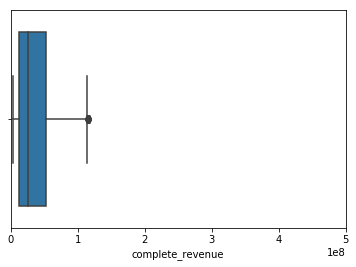

In [38]:
sns.boxplot(x=df['complete_revenue'])
plt.xlim(0,500000000)
plt.show()

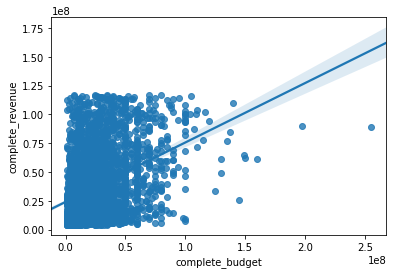

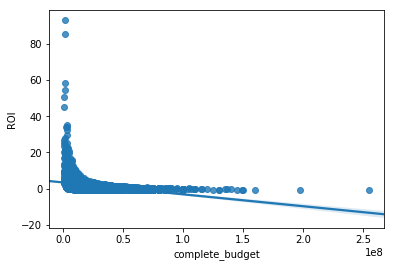

In [39]:
sns.regplot(y=df['complete_revenue'],x=df['complete_budget'])
plt.show() 

sns.regplot(y=df['ROI'],x=df['complete_budget'])
plt.show()

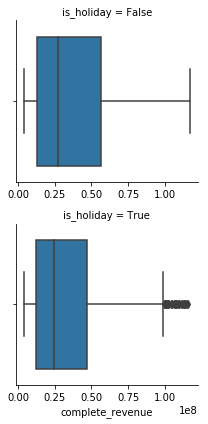

KruskalResult(statistic=7.0321424353794288, pvalue=0.0080059516823881051)

In [40]:
g = sns.FacetGrid(df[['is_holiday','complete_revenue','complete_budget']],row='is_holiday')
g.map(sns.boxplot, 'complete_revenue')
plt.show()

stats.kruskal(df[df['is_holiday'] == True]['complete_revenue'], df[df['is_holiday'] == False]['complete_revenue'])

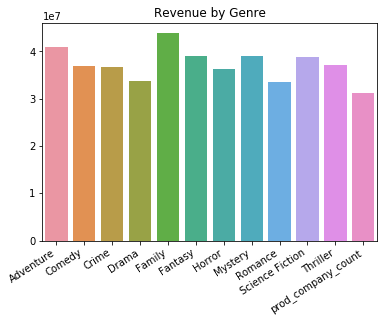

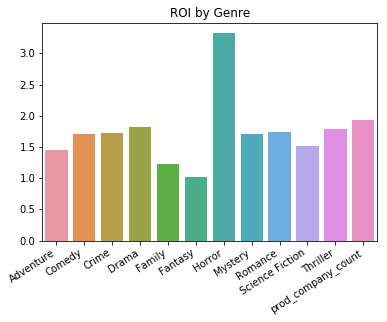

In [41]:
genres = list(df.iloc[:,4:24].columns)

genre_count = {}

for genre in genres:
    genre_count[genre] = df[df[genre] == 1]['complete_revenue'].count()

genre_list = [key for key,values in genre_count.items() if values > 200]

genre_mean = {}
genre_ROI = {}

for genre in genre_list:
    genre_mean[genre] = df[df[genre] == 1]['complete_revenue'].mean()
    genre_ROI[genre] = df[df[genre] == 1]['ROI'].mean()
    
sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_mean.values()])
plt.title('Revenue by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_ROI.values()])
plt.title('ROI by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

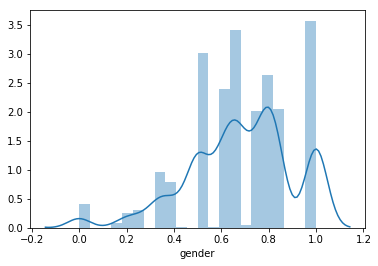

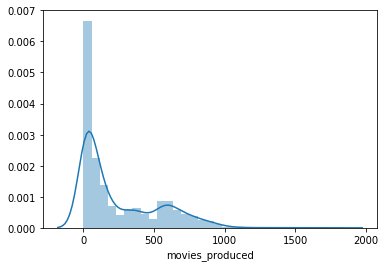

In [42]:
sns.distplot(df['gender'])
plt.show()

sns.distplot(df['movies_produced'])
plt.show()

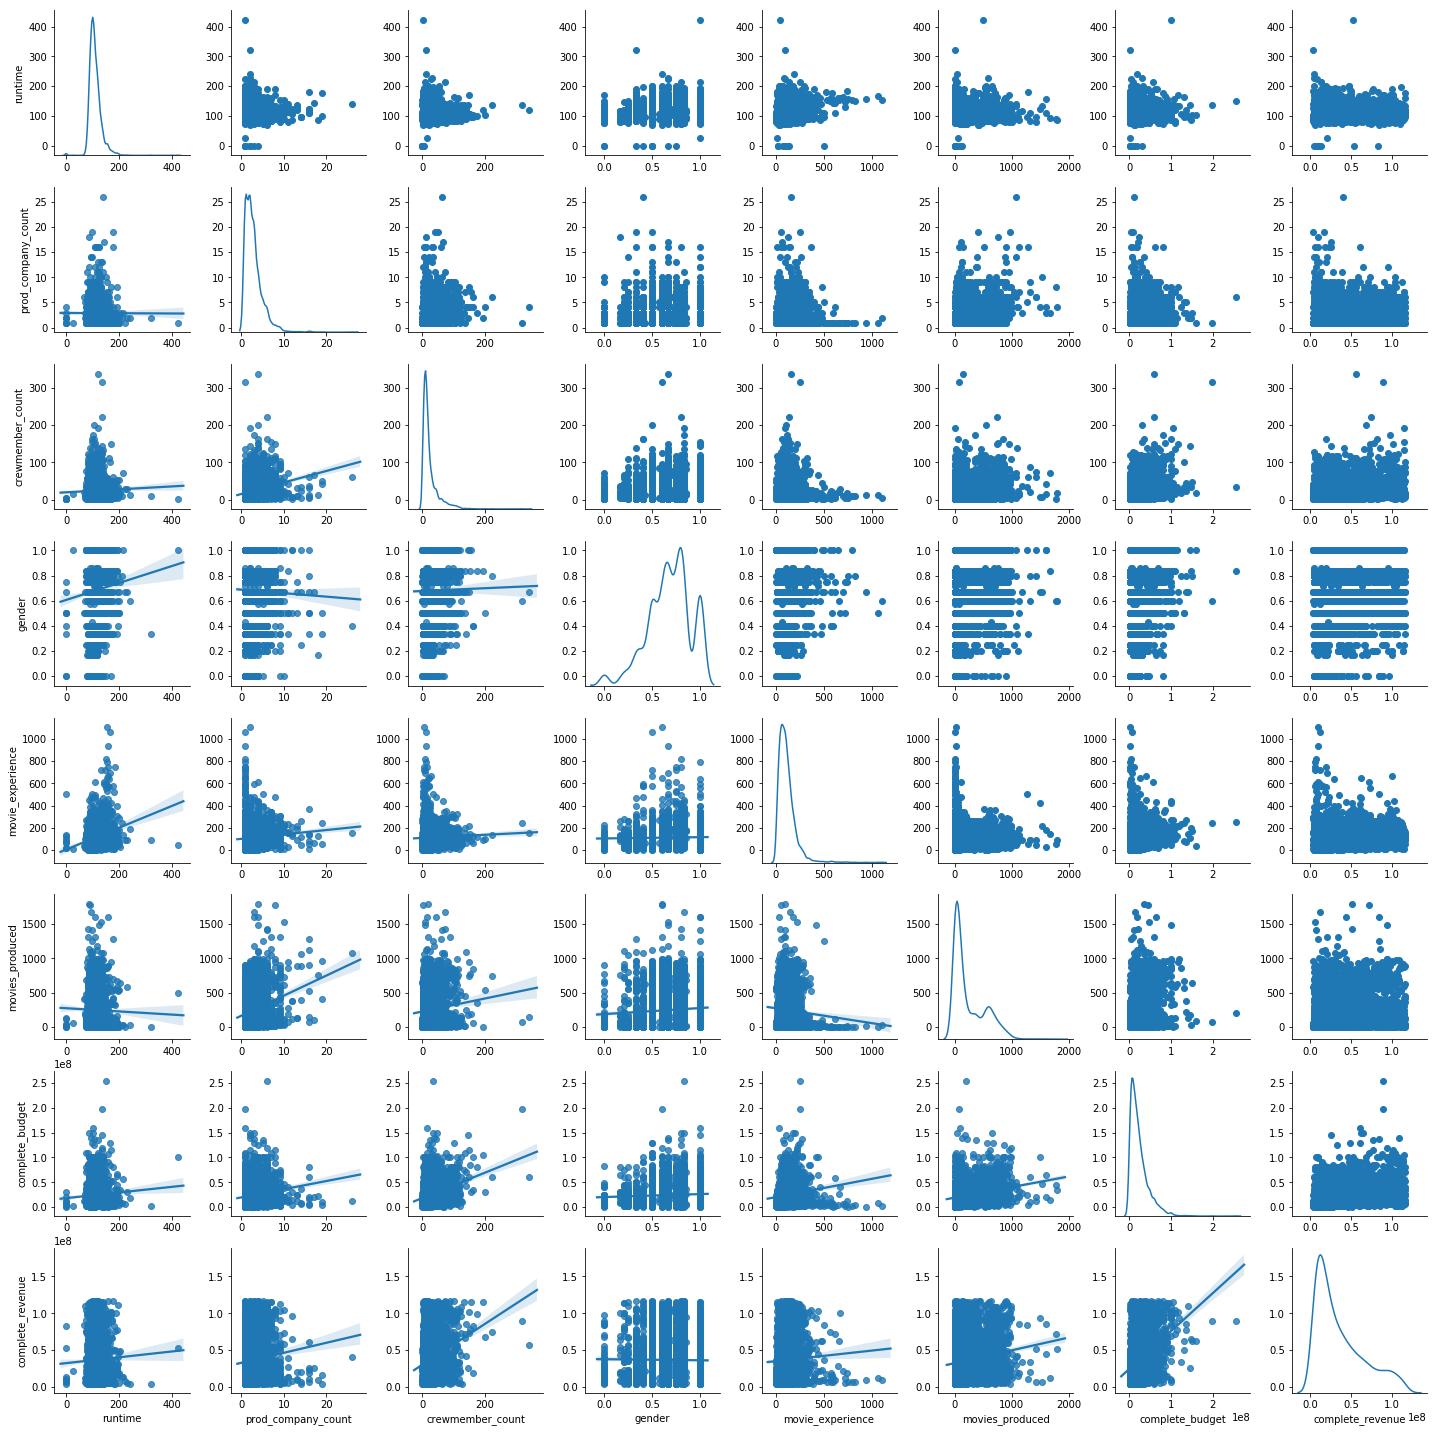

In [43]:
cols = ['runtime','prod_company_count','crewmember_count','gender','movie_experience','movies_produced','complete_budget','complete_revenue']

g = sns.PairGrid(df[cols], diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot)
g.map_diag(sns.kdeplot)

plt.show()

In [44]:
df.corr()[['complete_revenue','complete_budget','ROI','gross_margin']]

,complete_revenue,complete_budget,ROI,gross_margin
runtime,0.03,0.06,-0.02,-0.02
Action,0.03,0.15,-0.07,-0.07
Adventure,0.06,0.16,-0.04,-0.04
Animation,0.05,0.10,-0.01,-0.01
Comedy,0.01,-0.02,-0.02,-0.02
Crime,0.00,-0.00,-0.01,-0.01
Documentary,0.01,-0.04,0.09,0.09
Drama,-0.09,-0.09,-0.00,-0.00
Family,0.08,0.12,-0.04,-0.04
Fantasy,0.03,0.12,-0.06,-0.06


# Baseline Model - Budget on Revenue

In [87]:
x = df['log_budget']
y = df['complete_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)

In [88]:
def fit_model(model, x_train, y_train, x_test):
    model.fit(x_train,y_train)
    print(model.score(x_train,y_train))
    return(model.predict(x_test))

def error_plot(y_test, y_predict):
    plt.plot([0,y_test.max()],[0,y_test.max()],c='k')
    plt.scatter(x=y_test,y=y_predict,)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return(plt.show())

def error_hist(y_test, y_predict):
    percent_error = (y_predict - y_test) / y_test
    plt.hist(percent_error, bins=np.arange(-10,10,1))
    return(plt.show())

def test_model(model, x_train, y_train, x_test, y_test):
    y_predict = fit_model(model, x_train, y_train, x_test)
    error_plot(y_test, y_predict)
    error_hist(y_test, y_predict)
    return(np.mean((percent_error < .1) & (percent_error > -.1)))

0.141745952876


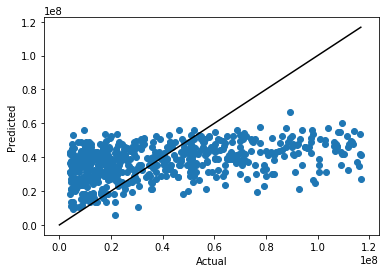

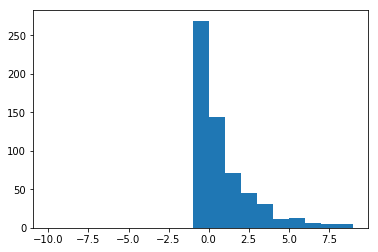

0.089850249584026626

In [89]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

test_model(lr, x_train, y_train, x_test, y_test)

# Try Decision Tree & Random Forest Regressor

In [45]:
drop_genres = set(genres) - set(genre_list)

model_data = df.drop(list(drop_genres),axis=1)
model_data = model_data.drop(['profit','ROI','release_date','title','log_revenue','gross_margin'],axis=1)

In [46]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'complete_revenue']
y = df_dum['complete_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'is_holiday', 'complete_budget',
       'is_sequel', 'log_budget', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error


dt = DecisionTreeRegressor(max_depth=10,max_features=None)

dt.fit(x_train,y_train)
y_predict = dt.predict(x_test)
dt.score(x_train,y_train)

0.57086649757326313

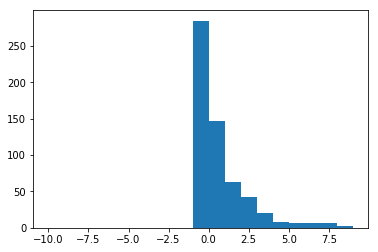

0.069883527454242922

In [48]:
percent_error = (y_predict - y_test) / y_test
plt.hist(percent_error, bins=np.arange(-10,10,1))
plt.show()

np.mean((percent_error < .1) & (percent_error > -.1))

In [50]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True);

In [51]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'complete_revenue']
y = df_dum['complete_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'is_holiday', 'complete_budget',
       'is_sequel', 'log_budget', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10,max_features=None)

rf.fit(x_train,y_train)
y_predict = rf.predict(x_test)
rf.score(x_train,y_train)

0.65082761220608254

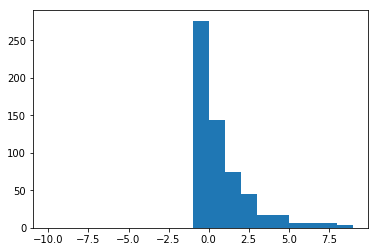

0.089850249584026626

In [53]:
percent_error = (y_predict - y_test) / y_test
plt.hist(percent_error, bins=np.arange(-10,10,1))
plt.show()

np.mean((percent_error < .1) & (percent_error > -.1))

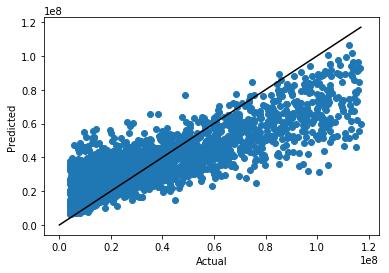

In [54]:
y_predict = rf.predict(x_train)

error_plot(y_train,y_predict)

In [55]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True);

ValueError: Length of values does not match length of index

In [ ]:
accurate_range = x_test.loc[(x_test['y_delta'] > -.1) & (x_test['y_delta'] < .1)]
accurate_range = accurate_range.join(df[['title','release_date']])

for column in accurate_range.columns:
    print(column)
    print(accurate_range[column].describe())
    print('-'*100)

In [ ]:
accurate_range.groupby(accurate_range['release_date'].dt.year).count()

In [ ]:
genre_p = accurate_range[genre_list].sum() / accurate_range.shape[0]
genre_t = df[genre_list].sum() / df.shape[0]

pd.concat([genre_p,genre_t], axis=1)

# Try predicting on a compact date range

In [ ]:
drop_genres = set(genres) - set(genre_list)

model_data = df.drop(list(drop_genres),axis=1)
model_data.drop(['profit','ROI','title','log_revenue','gross_margin'],axis=1,inplace=True)
model_data.drop(model_data[model_data['release_date'].dt.year < 2002].index,inplace=True)
model_data.drop('release_date',axis=1,inplace=True)

In [ ]:
df_dum = pd.get_dummies(model_data)

df_dum

x = df_dum.loc[:,df_dum.columns != 'complete_revenue']
y = df_dum['complete_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

In [ ]:
dt.fit(x_train,y_train)
y_predict = dt.predict(x_test)
dt.score(x_train,y_train)

In [ ]:
percent_error = (y_predict - y_test) / y_test
plt.hist(percent_error, bins=np.arange(-10,10,1))
plt.show()

np.mean((percent_error < .1) & (percent_error > -.1))

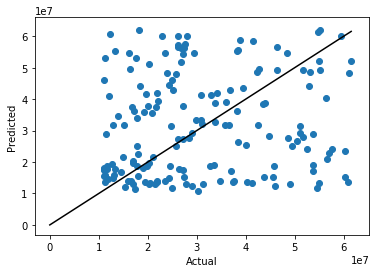

In [51]:
error_plot(y_test, y_predict)

# Try predicting revenue based on genre

In [54]:
drop_genres = set(genres) - set(genre_list)

model_data = df.drop(list(drop_genres),axis=1)
model_data.drop(['profit','ROI','title','log_revenue','gross_margin'],axis=1,inplace=True)
model_data.drop(model_data[model_data['release_date'].dt.year < 2002].index,inplace=True)
model_data.drop('release_date',axis=1,inplace=True)

In [55]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'complete_revenue']
y = df_dum['complete_revenue']

x_train = x.sample(frac=.8, random_state=30)

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

Adventure


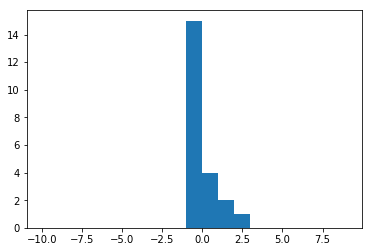

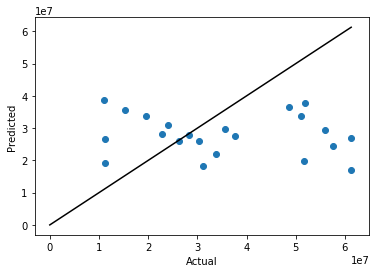

0.0909090909091
Comedy


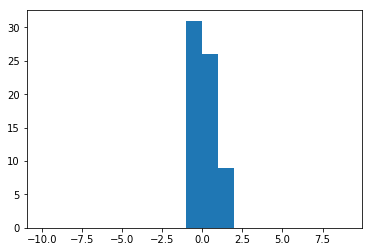

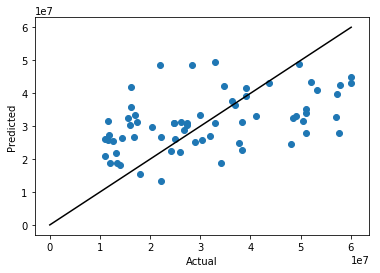

0.151515151515
Crime


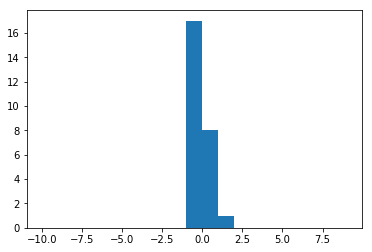

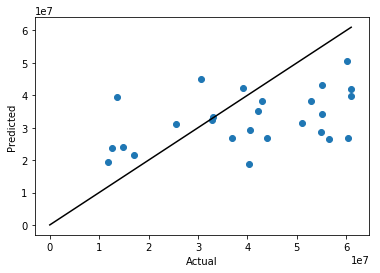

0.115384615385
Drama


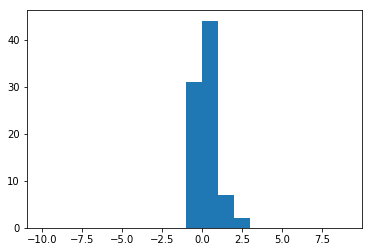

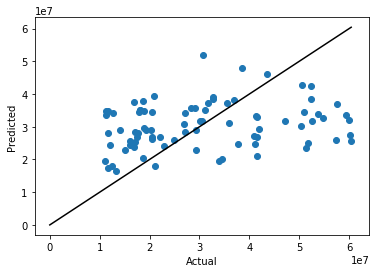

0.119047619048
Horror


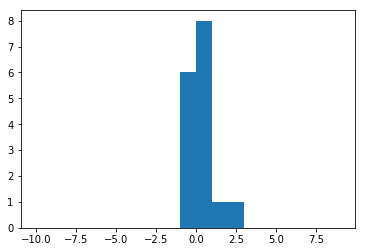

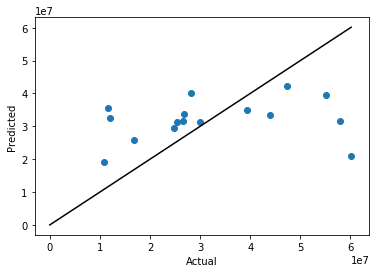

0.0625
Romance


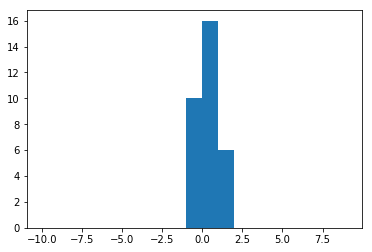

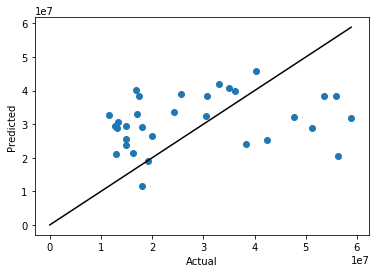

0.0625
Thriller


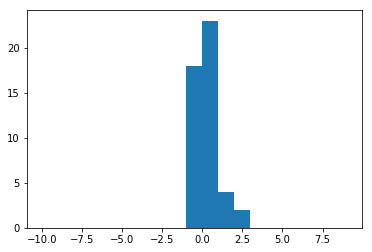

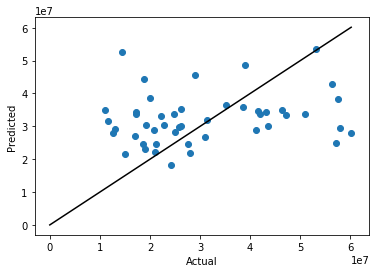

0.106382978723
prod_company_count


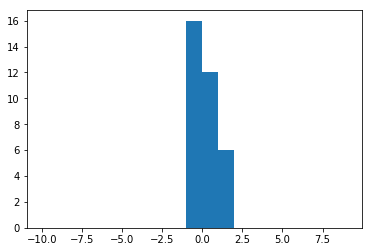

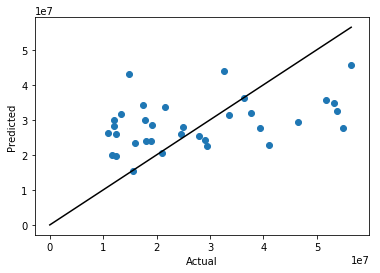

0.176470588235


In [56]:
for genre in genre_list:
    print(genre)
    x = df_dum.loc[:,df_dum.columns != 'complete_revenue']
    y = df_dum['complete_revenue']

    x = x[x[genre] == 1]
    y = y[x.index]
    
    x_train = x.sample(frac=.8, random_state=30)
    y_train = y[x_train.index]
    
    x_test = x.drop(x_train.index)
    y_test = y.drop(y_train.index)
    
    rf.fit(x_train,y_train)
    y_predict = rf.predict(x_test)
    percent_error = (y_predict - y_test) / y_test
    plt.hist(percent_error, bins=np.arange(-10,10,1))
    plt.show()
    plt.plot([0,y_test.max()],[0,y_test.max()],c='k')
    plt.scatter(x=y_test,y=y_predict,)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    print(np.mean((percent_error < .1) & (percent_error > -.1)))

In [57]:
feature_importance = pd.DataFrame(index=x_test.columns,data=rf.feature_importances_)
feature_importance.sort_values(by=0,ascending=False)

,0
movie_experience,0.21
crewmember_count,0.15
log_budget,0.13
movies_produced,0.11
complete_budget,0.10
runtime,0.07
gender,0.05
Comedy,0.02
Drama,0.02
Romance,0.02


- Dummy columns for top actors / actresses
- Try GB regressor
- Why the plot is misaligned?